# 

**Use case: Ambiguous reporting of onset-to-death delay distribution and erroneous CFR estimates**

In a scenario in which the case fatality risk (CFR) needs to be calculated for an ongoing, growing disease outbreak an onset-to-death delay distribution is required to calculate an unbiased CFR estimate, due to some individuals being infected but theiry outcome (i.e recovery or death) is unknown @nishiuraEarlyEpidemiologicalAssessment2009.

A line list of the current outbreak is available, but no estiates of the onset-to-death delay are available for this outbreak and there is not enough case data to reliably estimate it from the line list. Therefore a previously inferred onset-to-death distribution is searched and extracted from the literature for the same pathogen from a past outbreak.

The paper reporting the onset-to-death states:

> “… the average duration between the time when symptoms first appeared and death of the patients was estimated. The mean onset-to-death delay was of 14.5 days, with a standard deviation of 6.7.”

The ambiguous reporting of the esimates means the onset-to-death delay can be (mis)interpreted in several ways. The paper is reporting the summary statistics mean and standard deviation for a lognormal distribution they fitted to the data. The estimates could be misinterpreted as meanlog and sdlog do the lognormal distribution, or could be misinterpreted as the summary statistics of the raw data (i.e. sample statistics). The CFR calculation for an unbiased estimate requires a parametric probability density/mass function. Therefore, given the ambiguity we demonstrate the correct interpretation and three misinterpretations of the reported onset-to-death and show how the CFR varies as a result. We use the {simulist} and {cfr} R packages to simulate line list data and calculate the CFR, respectively @lambertSimulistSimulateDisease2024 and @gupteCfrEstimateDisease2024.

In [ ]:
#| echo: false
#| message: false
# Use case for reporting guidance paper #2- Mean of the sample reported
# ambiguously so it's confused with the mean of the lognormal distribution
library(simulist)
library(epiparameter)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: grates

Attaching package: 'grates'

The following objects are masked from 'package:lubridate':

    epiweek, isoweek, year

In [ ]:
#| echo: false
#| message: false
# Step 1: Simulating data for the use case with o-d lognormal and CFR of 30%
contact_distribution <- epiparameter(
  disease = "COVID-19",
  epi_dist = "contact distribution",
  prob_distribution = "pois",
  prob_distribution_params = c(mean = 3)
)

Citation cannot be created as author, year, journal or title is missing

Citation cannot be created as author, year, journal or title is missing

Using Linton N, Kobayashi T, Yang Y, Hayashi K, Akhmetzhanov A, Jung S, Yuan
B, Kinoshita R, Nishiura H (2020). "Incubation Period and Other
Epidemiological Characteristics of 2019 Novel Coronavirus Infections
with Right Truncation: A Statistical Analysis of Publicly Available
Case Data." _Journal of Clinical Medicine_. doi:10.3390/jcm9020538
<https://doi.org/10.3390/jcm9020538>.. 
To retrieve the citation use the 'get_citation' function

Returning data early with 2272 cases and 3246 total contacts (including cases).

NAs in cases and deaths are being replaced with 0s: Set `fill_NA = FALSE` to prevent this.

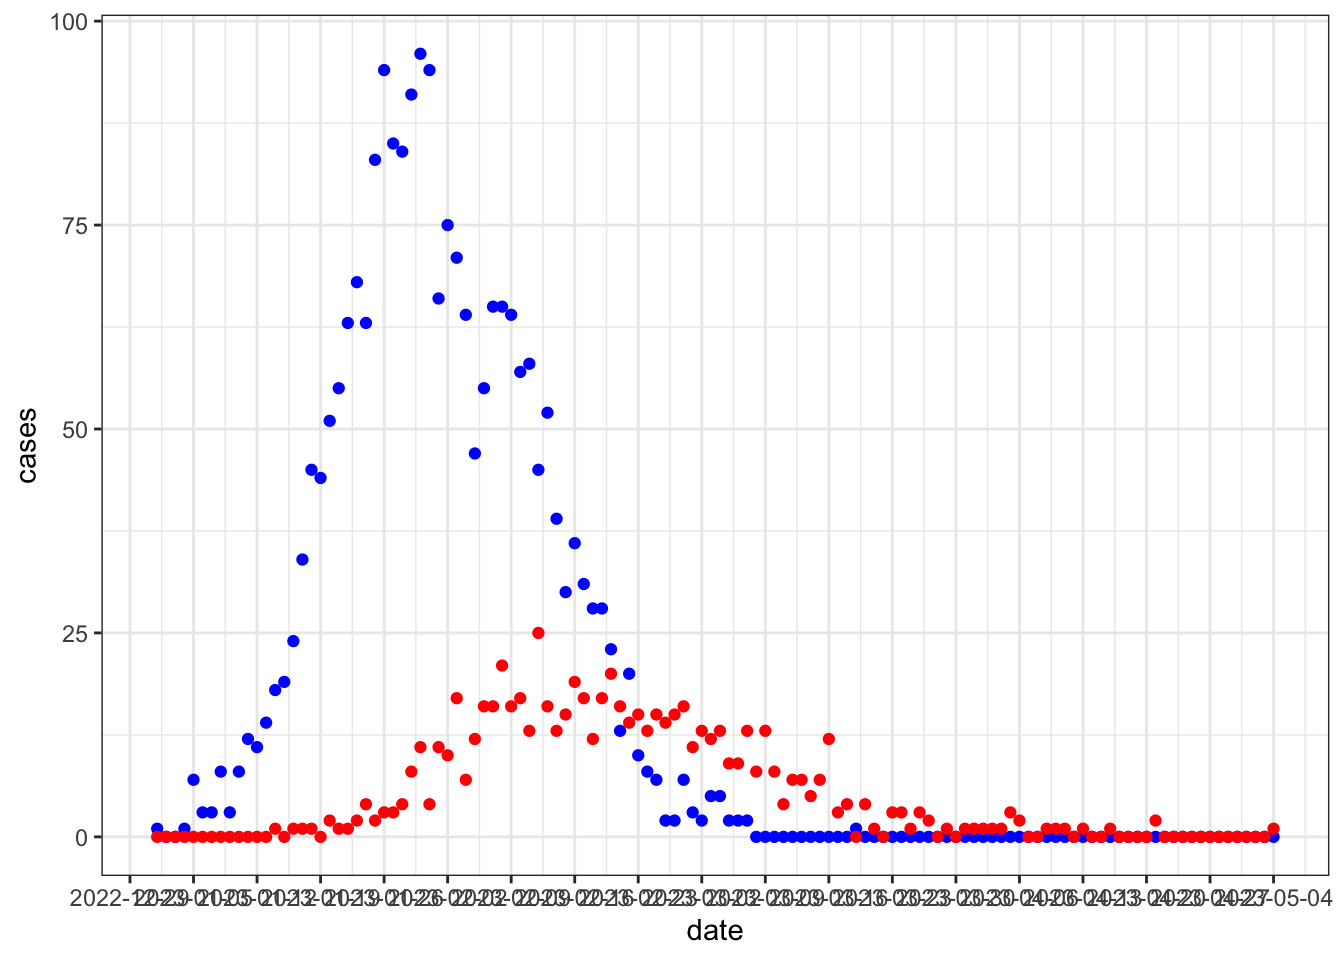

In [ ]:
#| echo: false
# STEP 2: Aggregation
linelist_covid <- linelist_covid %>%
  tidyr::pivot_wider(
    names_from = outcome,
    values_from = date_outcome
  ) %>%
  dplyr::rename(
    date_death = died,
    date_recovery = recovered
  )

incidence_COVID <- incidence2::incidence(
  linelist_covid, 
  date_index = c("date_onset", "date_death"), 
  interval = 1L
)

incidence_COVID$date_index <- as.Date(incidence_COVID$date_index)
covid_inc_cfr <- cfr::prepare_data(
  incidence_COVID, 
  cases_variable = "date_onset", 
  deaths_variable = "date_death"
)

In [ ]:
#| echo: false
# STEP 3: Truncating data
# Real-time point at 2023-01-09

real_time <- "2023-01-27"
incidence_rt_covid <- covid_inc_cfr[covid_inc_cfr$date <= real_time,]

In [ ]:
#| echo: false
# STEP 4: Converting parameters
true_dist_params <- get_parameters(o_d_COVID)
true_dist_summary_stats <- convert_params_to_summary_stats("lnorm", meanlog = true_dist_params[["meanlog"]], sdlog = true_dist_params[["sdlog"]])

In [ ]:
#| echo: false
# STEP 5: Problem statement

# We want to estimate the delay-adjusted CFR on our own outbreak data, and for this
# we look at the available literature where we find a publication that reports the delay
# from disease onset to death as follows:
# "... the average duration between the time when symptoms first appeared and
# death of the patients was estimated. The mean onset-death delay was of 14.5 days,
# with a standard deviation of 6.7"


# 14.5 and 6.7 are really distribution summary stats

# TRUE CFR

true_cfr <- cfr::cfr_static(
  incidence_rt_covid, 
  delay_density = function(x) {
    dlnorm(
      x, 
      meanlog = true_dist_params[["meanlog"]], 
      sdlog = true_dist_params[["sdlog"]]
    )
  }
)

# a) We think they are meanlog and sdlog
crf_assumed_params <- cfr::cfr_static(
  incidence_rt_covid, 
  delay_density = function(x) {
    dlnorm(
      x, 
      meanlog = true_dist_summary_stats[["mean"]], 
      sdlog = true_dist_summary_stats[["sd"]]
    )
  }
)

Total deaths = 22 and expected outcomes = 14 so setting expected outcomes = NA. If we were to assume
        total deaths = expected outcomes, it would produce an estimate of 1.

The correct interpretation can analytically convert the mean and standard deviation to the lognormal distribution parameters ($\mu$ = 2.86, $\sigma$ = 0.53) and parameterise the onset-to-death, resulting in a CFR of 0.3042, or 30.42%. Misinterpreting the estimates to be the lognormal parameters results in an overestimated CFR of NA. Assuming that the reported estimates are sample summary statistics, the distribution can be assumed, here we test the assumption that it is a lognormal (correct assumption) and a gamma distribution (incorrect assumption). The assumed parametric distribution form can be used to simulate a sample and the same distribution can be fit to that sample to estimate the parameters. In the case of assuming a lognormal distribution the CFR is estimated as 0.2681, whereas assuming a gamma distribution results in a CFR of 0.2426. The estimated CFR is biased in both cases but more so when the distribution is assumed incorrectly.